In [1]:
%%capture
%pip install -U 'rockfish[labs]' -f 'https://packages.rockfish.ai'

In [2]:
import io

import rockfish as rf
import rockfish.actions as ra
import rockfish.labs as rl

### Amplify on measurement field from timeseries data


In [3]:
timeseries_data = b"""\
customer,age,gender,category,amount,timestamp,fraud
C249282739,4,Male,transportation,6.18,1970-02-11,0
C1847494890,3,Male,transportation,30.34,1970-02-17,0
C1415998962,2,Female,food,26.58,1970-05-29,0
C528985379,3,Female,transportation,47.86,1970-02-25,0
C911364935,3,Male,transportation,29.67,1970-02-12,0
C469059843,5,Female,transportation,6.59,1970-04-15,0
C1938976805,2,Male,transportation,38.26,1970-04-11,0
C1692355722,2,Male,transportation,33.2,1970-01-03,0
C851156881,1,Male,transportation,2.89,1970-02-26,0
C985732014,2,Female,transportation,33.25,1970-04-04,0
C1896828249,2,Male,transportation,42.42,1970-04-13,0
C1548142512,4,Female,transportation,31.13,1970-02-13,0
C1092512638,3,Female,transportation,47.28,1970-05-08,0
C226835436,4,Female,food,24.48,1970-04-11,0
C232369406,5,Female,transportation,17.81,1970-03-30,0
C1002759277,1,Female,transportation,38.87,1970-06-11,0
C877486986,0,Female,transportation,2.03,1970-04-26,0
C2064491438,5,Female,transportation,37.83,1970-04-10,0
C1127983201,6,Female,transportation,6.54,1970-06-21,0
C1806072501,5,Male,transportation,0.06,1970-03-18,0
C1070277785,4,Female,wellnessandbeauty,300.58,1970-05-01,1
C1560676680,2,Female,otherservices,66.6,1970-01-01,1
"""

In [4]:
ts_dataset = rf.Dataset.from_csv(
    "Before_amplified", io.BytesIO(timeseries_data)
)
schema_metadata = rf.arrow.SchemaMetadata(
    metadata=["customer", "age", "gender"]
)
ts_dataset.table = rf.arrow.replace_schema_metadata(
    ts_dataset.table, schema_metadata
)
ts_dataset.to_pandas()

,customer,age,gender,category,amount,timestamp,fraud
0,C249282739,4,Male,transportation,6.18,1970-02-11,0
1,C1847494890,3,Male,transportation,30.34,1970-02-17,0
2,C1415998962,2,Female,food,26.58,1970-05-29,0
3,C528985379,3,Female,transportation,47.86,1970-02-25,0
4,C911364935,3,Male,transportation,29.67,1970-02-12,0
5,C469059843,5,Female,transportation,6.59,1970-04-15,0
6,C1938976805,2,Male,transportation,38.26,1970-04-11,0
7,C1692355722,2,Male,transportation,33.20,1970-01-03,0
8,C851156881,1,Male,transportation,2.89,1970-02-26,0
9,C985732014,2,Female,transportation,33.25,1970-04-04,0


In [5]:
# connect locally
conn = rf.Connection.local()

### Example 1

Amplify on one condition


In [6]:
# amplify fraud transaction by dropping non-fraud
post_amplify = ra.PostAmplify(
    {
        "query_ast": {
            "eq": ["fraud", 1],
        },
        "drop_match_percentage": 0.0,
        "drop_other_percentage": 0.5,
    }
)

save_amplified = ra.DatasetSave({"name": "After_amplified_1"})
builder = rf.WorkflowBuilder()
builder.add_dataset(ts_dataset)
builder.add_action(post_amplify, parents=[ts_dataset])
builder.add_action(save_amplified, parents=[post_amplify])
workflow = await builder.start(conn)

In [7]:
async for progress in workflow.progress("post-amplify"):
    print(progress)

2024-12-13T02:50:42.238573Z post-amplify:   0%
2024-12-13T02:50:42.254524Z post-amplify:  50%
2024-12-13T02:50:42.254988Z post-amplify: 100%


In [8]:
amplified_ts_dataset_1 = None
async for sds in workflow.datasets():
    amplified_ts_dataset_1 = await sds.to_local(conn)
amplified_ts_dataset_1.to_pandas()

,customer,age,gender,category,amount,timestamp,fraud
0,C1070277785,4,Female,wellnessandbeauty,300.58,1970-05-01,1
1,C1560676680,2,Female,otherservices,66.60,1970-01-01,1
2,C249282739,4,Male,transportation,6.18,1970-02-11,0
3,C528985379,3,Female,transportation,47.86,1970-02-25,0
4,C469059843,5,Female,transportation,6.59,1970-04-15,0
5,C1938976805,2,Male,transportation,38.26,1970-04-11,0
6,C985732014,2,Female,transportation,33.25,1970-04-04,0
7,C1548142512,4,Female,transportation,31.13,1970-02-13,0
8,C226835436,4,Female,food,24.48,1970-04-11,0
9,C877486986,0,Female,transportation,2.03,1970-04-26,0


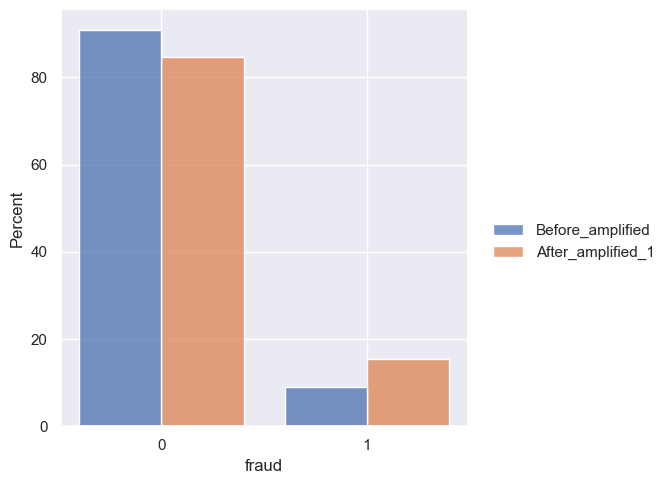

In [9]:
# before vs after amplifying fraud transactions
col = "fraud"
before_agg = rf.metrics.count_all(ts_dataset, col)
after_agg = rf.metrics.count_all(amplified_ts_dataset_1, col)
rl.vis.plot_bar([before_agg, after_agg], col, f"{col}_count")

### Example 2

Amplify on multi conditions


In [10]:
# amplify the conditions when their "gender" values are not "Female" and their "age" values are less than 4
post_amplify = ra.PostAmplify(
    {
        "query_ast": {
            "and": [
                {"lt": ["age", 4]},
                {"ne": ["gender", "Female"]},
            ]
        },
        "drop_match_percentage": 0.0,
        "drop_other_percentage": 0.5,
    }
)

save_amplified = ra.DatasetSave({"name": "After_amplified_2"})
builder = rf.WorkflowBuilder()
builder.add_dataset(ts_dataset)
builder.add_action(post_amplify, parents=[ts_dataset])
builder.add_action(save_amplified, parents=[post_amplify])
workflow = await builder.start(conn)

In [11]:
async for progress in workflow.progress("post-amplify"):
    print(progress)

2024-12-13T02:50:42.390991Z post-amplify:   0%
2024-12-13T02:50:42.391772Z post-amplify:  50%
2024-12-13T02:50:42.392216Z post-amplify: 100%


In [12]:
amplified_ts_dataset_2 = None
async for sds in workflow.datasets():
    amplified_ts_dataset_2 = await sds.to_local(conn)
amplified_ts_dataset_2.to_pandas()

,customer,age,gender,category,amount,timestamp,fraud
0,C1847494890,3,Male,transportation,30.34,1970-02-17,0
1,C911364935,3,Male,transportation,29.67,1970-02-12,0
2,C1938976805,2,Male,transportation,38.26,1970-04-11,0
3,C1692355722,2,Male,transportation,33.20,1970-01-03,0
4,C851156881,1,Male,transportation,2.89,1970-02-26,0
5,C1896828249,2,Male,transportation,42.42,1970-04-13,0
6,C469059843,5,Female,transportation,6.59,1970-04-15,0
7,C985732014,2,Female,transportation,33.25,1970-04-04,0
8,C1092512638,3,Female,transportation,47.28,1970-05-08,0
9,C226835436,4,Female,food,24.48,1970-04-11,0


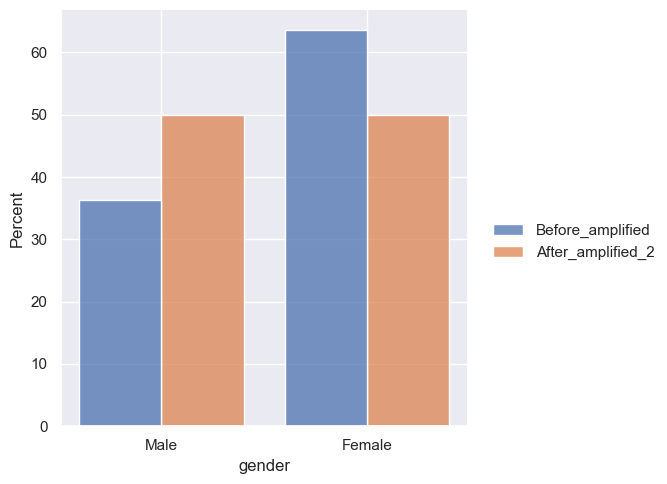

In [13]:
# before vs after amplifying the gender which is not as Female --> amplify Male
col = "gender"
before_agg = rf.metrics.count_all(ts_dataset, col)
after_agg = rf.metrics.count_all(amplified_ts_dataset_2, col)
rl.vis.plot_bar([before_agg, after_agg], col, f"{col}_count")

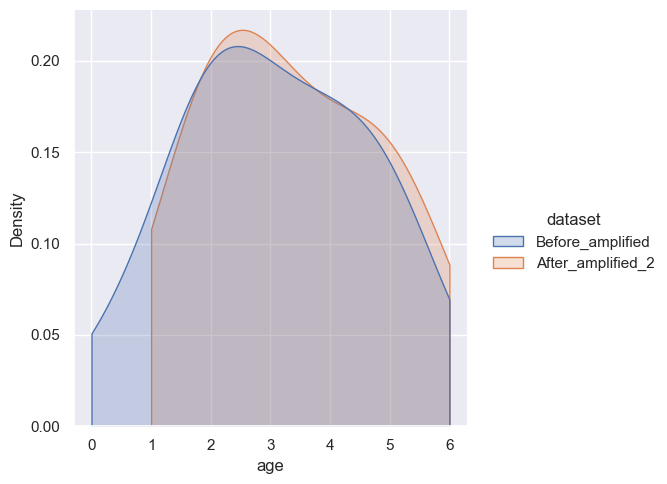

In [14]:
# before vs after amplifying the age less than 4
col = "age"
rl.vis.plot_kde([ts_dataset, amplified_ts_dataset_2], col)